In [1]:
import numpy as np
import gensim.downloader as api
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import os
from cuml.manifold import UMAP


In [2]:
import numpy as np
import os
from cuml.manifold import UMAP
from scipy.stats import spearmanr
import gensim.downloader as api

# Load the pre-trained FastText model
def load_fasttext_model():
    os.environ["GENSIM_DATA_DIR"] = "/teamspace/studios/this_studio/gensim-data"
    fasttext_model = api.load('fasttext-wiki-news-subwords-300')
    return fasttext_model

# Load SimLex-999 word similarity data
def load_simlex_999(file_path):
    """Loads SimLex-999 and returns word pairs with similarity scores."""
    data = []
    with open(file_path, 'r') as file:
        next(file)  # Skip header
        for line in file:
            parts = line.strip().split('\t')
            word1, word2, similarity_score = parts[0], parts[1], float(parts[3])
            data.append((word1, word2, similarity_score))
    return data

# Cosine similarity function for similarity evaluation
def cosine_similarity(v1, v2):
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    return np.dot(v1, v2) / (norm1 * norm2)

# Evaluate embeddings on the SimLex-999 data
def evaluate_embeddings(model, word_pairs):
    predicted_scores = []
    true_scores = []
    
    for word1, word2, true_score in word_pairs:
        if word1 in model and word2 in model:
            sim_score = cosine_similarity(model[word1], model[word2])
            predicted_scores.append(sim_score)
            true_scores.append(true_score)
    
    # Calculate Spearman correlation for word similarity performance
    correlation, _ = spearmanr(true_scores, predicted_scores)
    return correlation

# GPU-accelerated UMAP dimensionality reduction with progress display for variable min_dist
def umap_dimensionality_reduction_for_min_dist_range(embeddings, target_dim=2, min_dist_range=(0, 1), step=0.1):
    """Reduces dimensions using GPU-accelerated UMAP with varying `min_dist` in the specified range and steps."""
    results = {}
    
    for min_dist in np.arange(min_dist_range[0], min_dist_range[1] + step, step):
        print(f"Applying GPU-accelerated UMAP with min_dist={min_dist}...")
        # Initialize UMAP model
        umap_model = UMAP(n_components=target_dim, n_neighbors=15, min_dist=min_dist, random_state=42)
        # Fit and transform the embeddings to the target dimensionality
        umap_embeddings = umap_model.fit_transform(embeddings)
        
        # Store the UMAP embeddings for each min_dist value
        results[min_dist] = umap_embeddings
    
    return results

In [3]:
# File path for SimLex-999 dataset
simlex_file_path = '/teamspace/studios/pca/SimLex-999.txt'  # Update this path to your SimLex-999 file
target_dim = 2  # Set the target dimension to 2 for visualization
min_dist_range = (0.1, 1)  # Range of min_dist values
step = 0.1  # Step size for testing different min_dist values

In [4]:
# Load the FastText model
print("Loading FastText model...")
original_model = load_fasttext_model()


Loading FastText model...


In [5]:
# Load SimLex-999 word pairs with similarity scores
word_pairs = load_simlex_999(simlex_file_path)

In [6]:
def task_driven_dimensionality_reduction_umap(embeddings, word_pairs, model, target_dim=3, n_neighbors=15, min_dist=0.1):
    """
    Perform task-driven dimensionality reduction using UMAP.
    """
    # Initialize UMAP for dimensionality reduction
    umap_reducer = UMAP(n_components=target_dim, n_neighbors=15, min_dist=min_dist, metric='cosine')
    reduced_embeddings = umap_reducer.fit_transform(embeddings)
    
    # Create a reduced model
    optimized_model = {word: reduced_embeddings[i] for i, word in enumerate(model.index_to_key)}
    
    # Evaluate the reduction
    correlation = evaluate_embeddings(optimized_model, word_pairs)
    print(f"Spearman Correlation with UMAP (n_neighbors={15}, min_dist={min_dist}): {correlation:.4f}")
    
    return reduced_embeddings, correlation


In [7]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(1, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings1 = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings1 = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")

# Save UMAP results to a text file
results_file_path = "fasttextumap_results1.txt"

with open(results_file_path, "w") as file:
    
    for min_dist, correlation in zip(min_dist_values, correlations):  # Use the correlations list here
        file.write(f"min_dist={min_dist:.1f}, Spearman Correlation={correlation:.4f}\n")
    
print(f"Results saved to {results_file_path}")

UMAP Dimensionality Reduction Results:


Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.1): 0.2400
Spearman Correlation at min_dist=0.1: 0.2400
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.2): 0.2364
Spearman Correlation at min_dist=0.2: 0.2364
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.3): 0.1290
Spearman Correlation at min_dist=0.3: 0.1290
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.4): 0.2230
Spearman Correlation at min_dist=0.4: 0.2230
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.5): 0.0697
Spearman Correlation at min_dist=0.5: 0.0697
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.1788
Spearman Correlation at min_dist=0.6: 0.1788
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1600
Spearman Correlation at min_dist=0.7: 0.1600
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.8): 0.1993
Spearman Correlation at min_dist=0.8: 0.1993
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.9): 0.1691
Spearman C

In [8]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(1, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings2 = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings2 = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")

# Save UMAP results to a text file
results_file_path = "fasttextumap_results2.txt"

with open(results_file_path, "w") as file:
    
    for min_dist, correlation in zip(min_dist_values, correlations):  # Use the correlations list here
        file.write(f"min_dist={min_dist:.1f}, Spearman Correlation={correlation:.4f}\n")
    
print(f"Results saved to {results_file_path}")


UMAP Dimensionality Reduction Results:
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.1): 0.1673
Spearman Correlation at min_dist=0.1: 0.1673
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.2): 0.1640
Spearman Correlation at min_dist=0.2: 0.1640
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.3): 0.2421
Spearman Correlation at min_dist=0.3: 0.2421
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.4): 0.2173
Spearman Correlation at min_dist=0.4: 0.2173
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.5): 0.1829
Spearman Correlation at min_dist=0.5: 0.1829
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.1323
Spearman Correlation at min_dist=0.6: 0.1323
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1506
Spearman Correlation at min_dist=0.7: 0.1506
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.8): 0.1419
Spearman Correlation at min_dist=0.8: 0.1419
Spearman Correlation with UMAP (n_neighbo

In [9]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(1, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings3 = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings3 = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")

# Save UMAP results to a text file
results_file_path = "fasttextumap_results3.txt"

with open(results_file_path, "w") as file:
    
    for min_dist, correlation in zip(min_dist_values, correlations):  # Use the correlations list here
        file.write(f"min_dist={min_dist:.1f}, Spearman Correlation={correlation:.4f}\n")
    
print(f"Results saved to {results_file_path}")


UMAP Dimensionality Reduction Results:
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.1): 0.2040
Spearman Correlation at min_dist=0.1: 0.2040
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.2): 0.1899
Spearman Correlation at min_dist=0.2: 0.1899
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.3): 0.1495
Spearman Correlation at min_dist=0.3: 0.1495
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.4): 0.2237
Spearman Correlation at min_dist=0.4: 0.2237
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.5): 0.1998
Spearman Correlation at min_dist=0.5: 0.1998
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.1678
Spearman Correlation at min_dist=0.6: 0.1678
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1768
Spearman Correlation at min_dist=0.7: 0.1768
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.8): 0.1123
Spearman Correlation at min_dist=0.8: 0.1123
Spearman Correlation with UMAP (n_neighbo

In [10]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(1, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings4 = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings4 = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")

# Save UMAP results to a text file
results_file_path = "fasttextumap_results4.txt"

with open(results_file_path, "w") as file:
    
    for min_dist, correlation in zip(min_dist_values, correlations):  # Use the correlations list here
        file.write(f"min_dist={min_dist:.1f}, Spearman Correlation={correlation:.4f}\n")
    
print(f"Results saved to {results_file_path}")


UMAP Dimensionality Reduction Results:
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.1): 0.2067
Spearman Correlation at min_dist=0.1: 0.2067
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.2): 0.1802
Spearman Correlation at min_dist=0.2: 0.1802
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.3): 0.1959
Spearman Correlation at min_dist=0.3: 0.1959
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.4): 0.1635
Spearman Correlation at min_dist=0.4: 0.1635
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.5): 0.1232
Spearman Correlation at min_dist=0.5: 0.1232
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.1785
Spearman Correlation at min_dist=0.6: 0.1785
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1903
Spearman Correlation at min_dist=0.7: 0.1903
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.8): 0.1668
Spearman Correlation at min_dist=0.8: 0.1668
Spearman Correlation with UMAP (n_neighbo

In [11]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(1, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings5 = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings5 = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")

# Save UMAP results to a text file
results_file_path = "fasttextumap_results5.txt"

with open(results_file_path, "w") as file:
    
    for min_dist, correlation in zip(min_dist_values, correlations):  # Use the correlations list here
        file.write(f"min_dist={min_dist:.1f}, Spearman Correlation={correlation:.4f}\n")
    
print(f"Results saved to {results_file_path}")


UMAP Dimensionality Reduction Results:
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.1): 0.2269
Spearman Correlation at min_dist=0.1: 0.2269
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.2): 0.2245
Spearman Correlation at min_dist=0.2: 0.2245
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.3): 0.2186
Spearman Correlation at min_dist=0.3: 0.2186
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.4): 0.1939
Spearman Correlation at min_dist=0.4: 0.1939
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.5): 0.1762
Spearman Correlation at min_dist=0.5: 0.1762
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.1973
Spearman Correlation at min_dist=0.6: 0.1973
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1247
Spearman Correlation at min_dist=0.7: 0.1247
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.8): 0.1603
Spearman Correlation at min_dist=0.8: 0.1603
Spearman Correlation with UMAP (n_neighbo

In [14]:
import pandas as pd
# Save the 2D embeddings with word labels to a CSV file
def save_embeddings_to_csv(words, embeddings, file_path):
    print(f"Saving 2D embeddings to {file_path}...")
    df = pd.DataFrame(embeddings, columns=['x', 'y'])
    df['word'] = words
    df.to_csv(file_path, index=False)
    print("2D embeddings saved successfully.")

In [15]:

# Get words and their high-dimensional embeddings
words = original_model.index_to_key  # List of words in vocabulary
############# CHANGE NAME BY ADDING RESULT VALUE
file_path="FastText_UMAP_2d_word_embeddings_2421.csv"
# Save the embeddings and words to a CSV file
############# REPLACE optimized_embeddings WITH THE BEST ONE!
save_embeddings_to_csv(words, optimized_embeddings2, file_path)

Saving 2D embeddings to FastText_UMAP_2d_word_embeddings_2421.csv...


2D embeddings saved successfully.


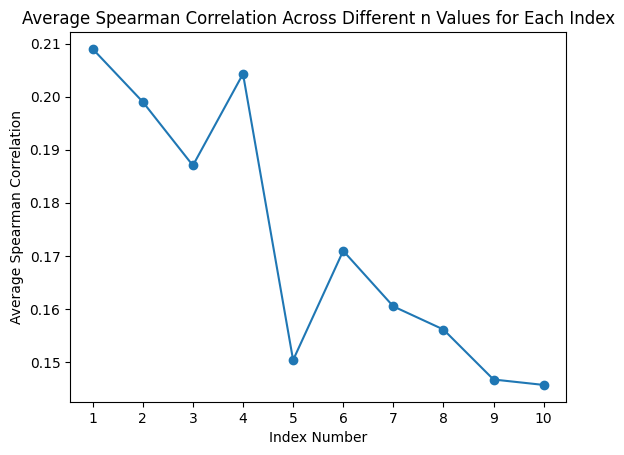

In [1]:
import matplotlib.pyplot as plt

# spearman_correlations_n5 = [0.2166, 0.1728, 0.1662, 0.2061, 0.2228, 0.1463, 0.2007, 0.1542, 0.2303, 0.1846]
# spearman_correlations_n10 = [0.2162, 0.2117, 0.2200, 0.1586, 0.1735, 0.1282, 0.1075, 0.1819, 0.1434, 0.1709]
# spearman_correlations_n15 = [0.2391, 0.2319, 0.1743, 0.1967, 0.2112, 0.2084, 0.1760, 0.1957, 0.1889, 0.1718]
# spearman_correlations_n20 = [0.2467, 0.2074, 0.1986, 0.2203, 0.1701, 0.1653, 0.1956, 0.1588, 0.1410, 0.1697]
# spearman_correlations_n25 = [0.2103, 0.2334, 0.2004, 0.1760, 0.2004, 0.2021, 0.1766, 0.2071, 0.1895, 0.1689]

spearman_correlations_list1 = [0.2400, 0.2364, 0.1290, 0.2230, 0.0697, 0.1788, 0.1600, 0.1993, 0.1691, 0.1789]
spearman_correlations_list2 = [0.1673, 0.1640, 0.2421, 0.2173, 0.1829, 0.1323, 0.1506, 0.1419, 0.1575, 0.1234]
spearman_correlations_list3 = [0.2040, 0.1899, 0.1495, 0.2237, 0.1998, 0.1678, 0.1768, 0.1123, 0.1206, 0.1715]
spearman_correlations_list4 = [0.2067, 0.1802, 0.1959, 0.1635, 0.1232, 0.1785, 0.1903, 0.1668, 0.1269, 0.0894]
spearman_correlations_list5 = [0.2269, 0.2245, 0.2186, 0.1939, 0.1762, 0.1973, 0.1247, 0.1603, 0.1594, 0.1652]

# Combine all lists into a single list of lists
# all_lists = [
#     spearman_correlations_n5,
#     spearman_correlations_n10,
#     spearman_correlations_n15,
#     spearman_correlations_n20,
#     spearman_correlations_n25,
# ]
all_lists = [
    spearman_correlations_list1,
    spearman_correlations_list2,
    spearman_correlations_list3,
    spearman_correlations_list4,
    spearman_correlations_list5,
]

# Calculate the average value for each index across all lists
index_averages = []
for i in range(len(spearman_correlations_list1)):  # Iterate through indices (0 to 9)
    index_values = [lst[i] for lst in all_lists]  # Get the value at index i from each list
    index_average = sum(index_values) / len(index_values)
    index_averages.append(index_average)

# Create a list of index numbers for the x-axis
index_numbers = list(range(1, len(spearman_correlations_list1) + 1))  # 1 to 10

# Plot the index averages in a line graph
plt.plot(index_numbers, index_averages, marker='o')

# Add labels and title
plt.xlabel("Index Number")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different n Values for Each Index")

# Customize the x-axis ticks
plt.xticks(index_numbers)

# Display the plot
plt.show()

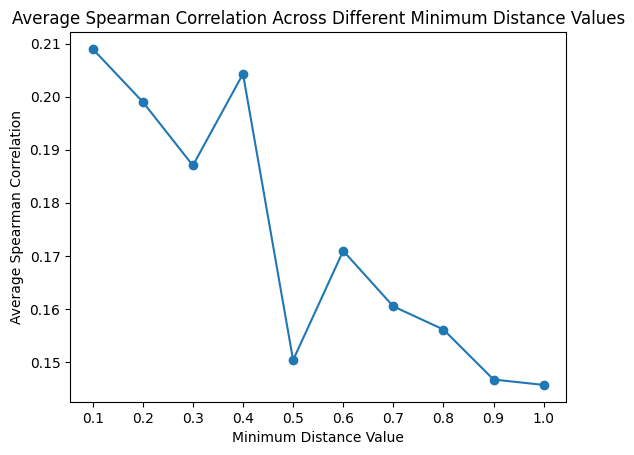

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fasttext_spearman_correlations_list1 = [0.2400, 0.2364, 0.1290, 0.2230, 0.0697, 0.1788, 0.1600, 0.1993, 0.1691, 0.1789]
fasttext_spearman_correlations_list2 = [0.1673, 0.1640, 0.2421, 0.2173, 0.1829, 0.1323, 0.1506, 0.1419, 0.1575, 0.1234]
fasttext_spearman_correlations_list3 = [0.2040, 0.1899, 0.1495, 0.2237, 0.1998, 0.1678, 0.1768, 0.1123, 0.1206, 0.1715]
fasttext_spearman_correlations_list4 = [0.2067, 0.1802, 0.1959, 0.1635, 0.1232, 0.1785, 0.1903, 0.1668, 0.1269, 0.0894]
fasttext_spearman_correlations_list5 = [0.2269, 0.2245, 0.2186, 0.1939, 0.1762, 0.1973, 0.1247, 0.1603, 0.1594, 0.1652]

all_lists = [
    spearman_correlations_list1,
    spearman_correlations_list2,
    spearman_correlations_list3,
    spearman_correlations_list4,
    spearman_correlations_list5,
]

# Calculate the average value for each index across all lists
index_averages = []
for i in range(len(spearman_correlations_list1)):
    index_values = [lst[i] for lst in all_lists]
    index_average = sum(index_values) / len(index_values)
    index_averages.append(index_average)

# Create a list of minimum distance values from 0.1 to 1.0 with intervals of 0.1
distance_values = np.arange(0.1, 1.1, 0.1)  # [0.1, 0.2, 0.3, ..., 0.9, 1.0]

# Plot the index averages in a line graph
plt.plot(distance_values, index_averages, marker='o')

# Add labels and title
plt.xlabel("Minimum Distance Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Minimum Distance Values")

# Customize the x-axis ticks
plt.xticks(distance_values)

# Display the plot
plt.show()

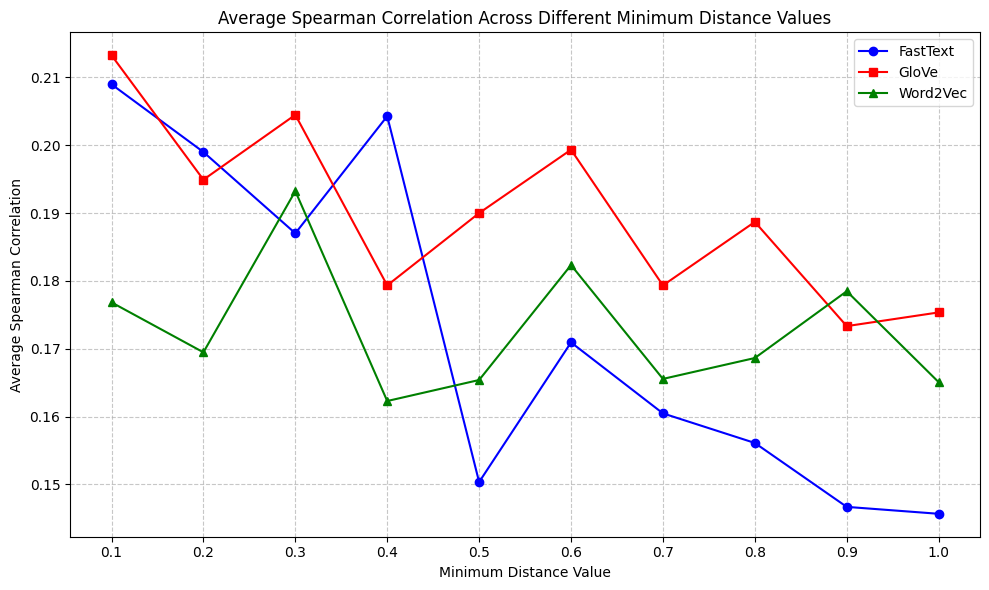

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# FastText correlations
fasttext_spearman_correlations_list1 = [0.2400, 0.2364, 0.1290, 0.2230, 0.0697, 0.1788, 0.1600, 0.1993, 0.1691, 0.1789]
fasttext_spearman_correlations_list2 = [0.1673, 0.1640, 0.2421, 0.2173, 0.1829, 0.1323, 0.1506, 0.1419, 0.1575, 0.1234]
fasttext_spearman_correlations_list3 = [0.2040, 0.1899, 0.1495, 0.2237, 0.1998, 0.1678, 0.1768, 0.1123, 0.1206, 0.1715]
fasttext_spearman_correlations_list4 = [0.2067, 0.1802, 0.1959, 0.1635, 0.1232, 0.1785, 0.1903, 0.1668, 0.1269, 0.0894]
fasttext_spearman_correlations_list5 = [0.2269, 0.2245, 0.2186, 0.1939, 0.1762, 0.1973, 0.1247, 0.1603, 0.1594, 0.1652]

# GloVe correlations
glove_spearman_correlations_list1 = [0.2172, 0.2012, 0.2333, 0.1664, 0.1905, 0.1974, 0.1576, 0.1808, 0.1821, 0.1847]
glove_spearman_correlations_list2 = [0.2288, 0.1783, 0.2056, 0.1762, 0.1822, 0.2113, 0.1732, 0.1864, 0.1443, 0.1840]
glove_spearman_correlations_list3 = [0.2342, 0.2060, 0.1944, 0.2179, 0.1619, 0.1601, 0.1990, 0.2112, 0.1740, 0.1859]
glove_spearman_correlations_list4 = [0.1533, 0.1802, 0.2030, 0.1834, 0.2163, 0.2131, 0.1954, 0.1904, 0.1833, 0.1722]
glove_spearman_correlations_list5 = [0.2328, 0.2089, 0.1861, 0.1528, 0.1991, 0.2148, 0.1715, 0.1747, 0.1830, 0.1500]


# Word2Vec correlations
word2vec_spearman_correlations_list1 = [0.1920, 0.1630, 0.1921, 0.1708, 0.1565, 0.1832, 0.1615, 0.1966, 0.1430, 0.1677]
word2vec_spearman_correlations_list2 = [0.1559, 0.1714, 0.2035, 0.1615, 0.1575, 0.1399, 0.1449, 0.1707, 0.1924, 0.1702]
word2vec_spearman_correlations_list3 = [0.1845, 0.1731, 0.2101, 0.1334, 0.1769, 0.1776, 0.1999, 0.1750, 0.1731, 0.1648]
word2vec_spearman_correlations_list4 = [0.1795, 0.1465, 0.1898, 0.1844, 0.1589, 0.2447, 0.1557, 0.1527, 0.2140, 0.1664]
word2vec_spearman_correlations_list5 = [0.1723, 0.1934, 0.1707, 0.1614, 0.1772, 0.1663, 0.1658, 0.1482, 0.1699, 0.1563]

# Group lists by model
fasttext_lists = [
    fasttext_spearman_correlations_list1,
    fasttext_spearman_correlations_list2,
    fasttext_spearman_correlations_list3,
    fasttext_spearman_correlations_list4,
    fasttext_spearman_correlations_list5,
]

glove_lists = [
    glove_spearman_correlations_list1,
    glove_spearman_correlations_list2,
    glove_spearman_correlations_list3,
    glove_spearman_correlations_list4,
    glove_spearman_correlations_list5,
]

word2vec_lists = [
    word2vec_spearman_correlations_list1,
    word2vec_spearman_correlations_list2,
    word2vec_spearman_correlations_list3,
    word2vec_spearman_correlations_list4,
    word2vec_spearman_correlations_list5,
]

# Function to calculate average correlations for each model
def calculate_averages(model_lists):
    # Calculate the average value for each index across all lists
    index_averages = []
    for i in range(len(model_lists[0])):
        index_values = [lst[i] for lst in model_lists]
        index_average = sum(index_values) / len(index_values)
        index_averages.append(index_average)
    return index_averages

# Calculate averages for each model
fasttext_averages = calculate_averages(fasttext_lists)
glove_averages = calculate_averages(glove_lists)
word2vec_averages = calculate_averages(word2vec_lists)

# Create a list of minimum distance values from 0.1 to 1.0 with intervals of 0.1
distance_values = np.arange(0.1, 1.1, 0.1)  # [0.1, 0.2, 0.3, ..., 0.9, 1.0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each model with different colors
plt.plot(distance_values, fasttext_averages, marker='o', color='blue', label='FastText')
plt.plot(distance_values, glove_averages, marker='s', color='red', label='GloVe')
plt.plot(distance_values, word2vec_averages, marker='^', color='green', label='Word2Vec')

# Add labels and title
plt.xlabel("Minimum Distance Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Minimum Distance Values")

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize the x-axis ticks
plt.xticks(distance_values)

# Add legend
plt.legend(loc='best')

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

[0.20898, 0.199, 0.18702, 0.20428000000000002, 0.15036, 0.17094, 0.16048, 0.15612, 0.1467, 0.14568]
[0.21326, 0.19491999999999998, 0.20448, 0.17934, 0.19, 0.19934000000000002, 0.17934, 0.1887, 0.17334, 0.17536000000000002]
[0.17684, 0.16948000000000002, 0.19323999999999997, 0.1623, 0.16540000000000002, 0.18234, 0.16555999999999998, 0.16864, 0.17847999999999997, 0.16507999999999998]


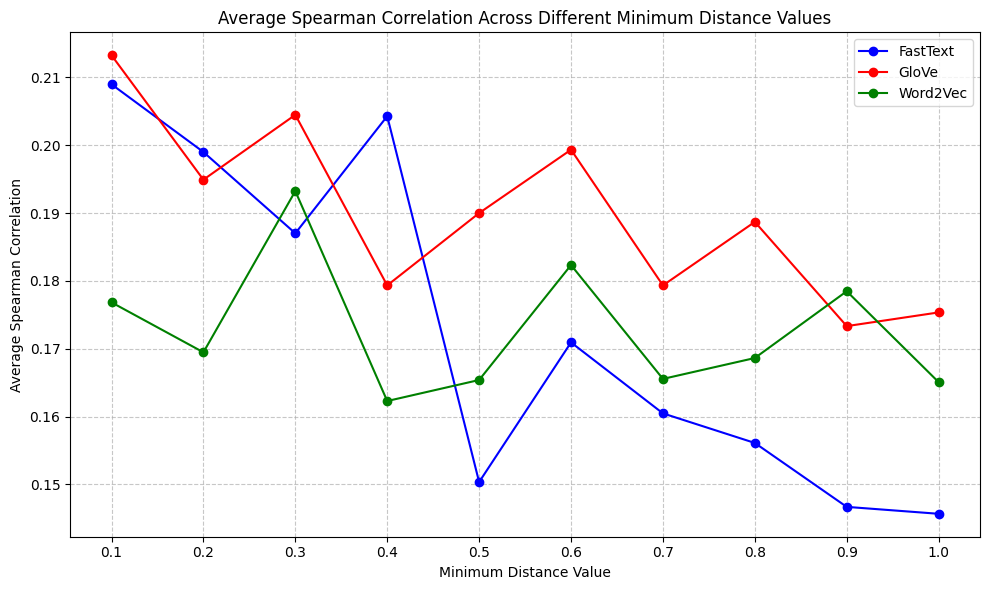

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# FastText correlations
fasttext_spearman_correlations_list1 = [0.2400, 0.2364, 0.1290, 0.2230, 0.0697, 0.1788, 0.1600, 0.1993, 0.1691, 0.1789]
fasttext_spearman_correlations_list2 = [0.1673, 0.1640, 0.2421, 0.2173, 0.1829, 0.1323, 0.1506, 0.1419, 0.1575, 0.1234]
fasttext_spearman_correlations_list3 = [0.2040, 0.1899, 0.1495, 0.2237, 0.1998, 0.1678, 0.1768, 0.1123, 0.1206, 0.1715]
fasttext_spearman_correlations_list4 = [0.2067, 0.1802, 0.1959, 0.1635, 0.1232, 0.1785, 0.1903, 0.1668, 0.1269, 0.0894]
fasttext_spearman_correlations_list5 = [0.2269, 0.2245, 0.2186, 0.1939, 0.1762, 0.1973, 0.1247, 0.1603, 0.1594, 0.1652]

# GloVe correlations
glove_spearman_correlations_list1 = [0.2172, 0.2012, 0.2333, 0.1664, 0.1905, 0.1974, 0.1576, 0.1808, 0.1821, 0.1847]
glove_spearman_correlations_list2 = [0.2288, 0.1783, 0.2056, 0.1762, 0.1822, 0.2113, 0.1732, 0.1864, 0.1443, 0.1840]
glove_spearman_correlations_list3 = [0.2342, 0.2060, 0.1944, 0.2179, 0.1619, 0.1601, 0.1990, 0.2112, 0.1740, 0.1859]
glove_spearman_correlations_list4 = [0.1533, 0.1802, 0.2030, 0.1834, 0.2163, 0.2131, 0.1954, 0.1904, 0.1833, 0.1722]
glove_spearman_correlations_list5 = [0.2328, 0.2089, 0.1861, 0.1528, 0.1991, 0.2148, 0.1715, 0.1747, 0.1830, 0.1500]


# Word2Vec correlations
word2vec_spearman_correlations_list1 = [0.1920, 0.1630, 0.1921, 0.1708, 0.1565, 0.1832, 0.1615, 0.1966, 0.1430, 0.1677]
word2vec_spearman_correlations_list2 = [0.1559, 0.1714, 0.2035, 0.1615, 0.1575, 0.1399, 0.1449, 0.1707, 0.1924, 0.1702]
word2vec_spearman_correlations_list3 = [0.1845, 0.1731, 0.2101, 0.1334, 0.1769, 0.1776, 0.1999, 0.1750, 0.1731, 0.1648]
word2vec_spearman_correlations_list4 = [0.1795, 0.1465, 0.1898, 0.1844, 0.1589, 0.2447, 0.1557, 0.1527, 0.2140, 0.1664]
word2vec_spearman_correlations_list5 = [0.1723, 0.1934, 0.1707, 0.1614, 0.1772, 0.1663, 0.1658, 0.1482, 0.1699, 0.1563]

# Group lists by model
fasttext_lists = [
    fasttext_spearman_correlations_list1,
    fasttext_spearman_correlations_list2,
    fasttext_spearman_correlations_list3,
    fasttext_spearman_correlations_list4,
    fasttext_spearman_correlations_list5,
]

glove_lists = [
    glove_spearman_correlations_list1,
    glove_spearman_correlations_list2,
    glove_spearman_correlations_list3,
    glove_spearman_correlations_list4,
    glove_spearman_correlations_list5,
]

word2vec_lists = [
    word2vec_spearman_correlations_list1,
    word2vec_spearman_correlations_list2,
    word2vec_spearman_correlations_list3,
    word2vec_spearman_correlations_list4,
    word2vec_spearman_correlations_list5,
]

# Function to calculate average correlations for each model
def calculate_averages(model_lists):
    # Calculate the average value for each index across all lists
    index_averages = []
    for i in range(len(model_lists[0])):
        index_values = [lst[i] for lst in model_lists]
        index_average = sum(index_values) / len(index_values)
        index_averages.append(index_average)
    return index_averages

# Calculate averages for each model
fasttext_averages = calculate_averages(fasttext_lists)
glove_averages = calculate_averages(glove_lists)
word2vec_averages = calculate_averages(word2vec_lists)

# Create a list of minimum distance values from 0.1 to 1.0 with intervals of 0.1
distance_values = np.arange(0.1, 1.1, 0.1)  # [0.1, 0.2, 0.3, ..., 0.9, 1.0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each model with different colors
plt.plot(distance_values, fasttext_averages, marker='o', color='blue', label='FastText')
plt.plot(distance_values, glove_averages, marker='o', color='red', label='GloVe')
plt.plot(distance_values, word2vec_averages, marker='o', color='green', label='Word2Vec')
print(fasttext_averages)
print(glove_averages)
print(word2vec_averages)

# Add labels and title
plt.xlabel("Minimum Distance Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Minimum Distance Values")

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize the x-axis ticks
plt.xticks(distance_values)

# Add legend
plt.legend(loc='best')

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

[0.20898, 0.199, 0.18702, 0.20428000000000002, 0.15036, 0.17094, 0.16048, 0.15612, 0.1467, 0.14568]
[0.21326, 0.19491999999999998, 0.20448, 0.17934, 0.19, 0.19934000000000002, 0.17934, 0.1887, 0.17334, 0.17536000000000002]
[0.17684, 0.16948000000000002, 0.19323999999999997, 0.1623, 0.16540000000000002, 0.18234, 0.16555999999999998, 0.16864, 0.17847999999999997, 0.16507999999999998]


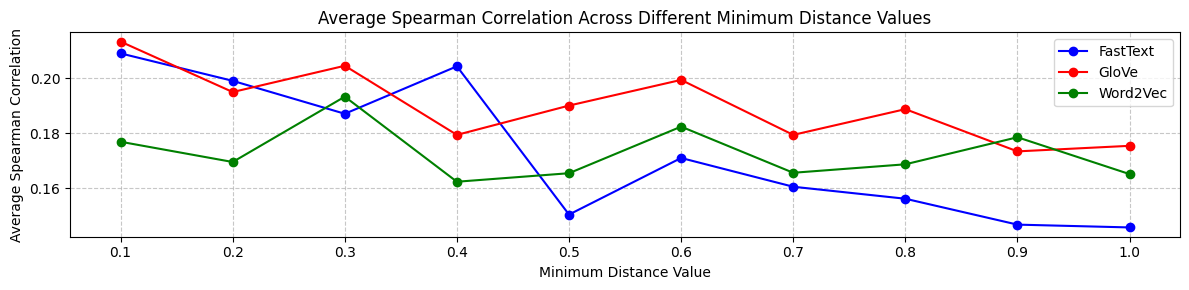

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# FastText correlations
fasttext_spearman_correlations_list1 = [0.2400, 0.2364, 0.1290, 0.2230, 0.0697, 0.1788, 0.1600, 0.1993, 0.1691, 0.1789]
fasttext_spearman_correlations_list2 = [0.1673, 0.1640, 0.2421, 0.2173, 0.1829, 0.1323, 0.1506, 0.1419, 0.1575, 0.1234]
fasttext_spearman_correlations_list3 = [0.2040, 0.1899, 0.1495, 0.2237, 0.1998, 0.1678, 0.1768, 0.1123, 0.1206, 0.1715]
fasttext_spearman_correlations_list4 = [0.2067, 0.1802, 0.1959, 0.1635, 0.1232, 0.1785, 0.1903, 0.1668, 0.1269, 0.0894]
fasttext_spearman_correlations_list5 = [0.2269, 0.2245, 0.2186, 0.1939, 0.1762, 0.1973, 0.1247, 0.1603, 0.1594, 0.1652]

# GloVe correlations
glove_spearman_correlations_list1 = [0.2172, 0.2012, 0.2333, 0.1664, 0.1905, 0.1974, 0.1576, 0.1808, 0.1821, 0.1847]
glove_spearman_correlations_list2 = [0.2288, 0.1783, 0.2056, 0.1762, 0.1822, 0.2113, 0.1732, 0.1864, 0.1443, 0.1840]
glove_spearman_correlations_list3 = [0.2342, 0.2060, 0.1944, 0.2179, 0.1619, 0.1601, 0.1990, 0.2112, 0.1740, 0.1859]
glove_spearman_correlations_list4 = [0.1533, 0.1802, 0.2030, 0.1834, 0.2163, 0.2131, 0.1954, 0.1904, 0.1833, 0.1722]
glove_spearman_correlations_list5 = [0.2328, 0.2089, 0.1861, 0.1528, 0.1991, 0.2148, 0.1715, 0.1747, 0.1830, 0.1500]


# Word2Vec correlations
word2vec_spearman_correlations_list1 = [0.1920, 0.1630, 0.1921, 0.1708, 0.1565, 0.1832, 0.1615, 0.1966, 0.1430, 0.1677]
word2vec_spearman_correlations_list2 = [0.1559, 0.1714, 0.2035, 0.1615, 0.1575, 0.1399, 0.1449, 0.1707, 0.1924, 0.1702]
word2vec_spearman_correlations_list3 = [0.1845, 0.1731, 0.2101, 0.1334, 0.1769, 0.1776, 0.1999, 0.1750, 0.1731, 0.1648]
word2vec_spearman_correlations_list4 = [0.1795, 0.1465, 0.1898, 0.1844, 0.1589, 0.2447, 0.1557, 0.1527, 0.2140, 0.1664]
word2vec_spearman_correlations_list5 = [0.1723, 0.1934, 0.1707, 0.1614, 0.1772, 0.1663, 0.1658, 0.1482, 0.1699, 0.1563]

# Group lists by model
fasttext_lists = [
    fasttext_spearman_correlations_list1,
    fasttext_spearman_correlations_list2,
    fasttext_spearman_correlations_list3,
    fasttext_spearman_correlations_list4,
    fasttext_spearman_correlations_list5,
]

glove_lists = [
    glove_spearman_correlations_list1,
    glove_spearman_correlations_list2,
    glove_spearman_correlations_list3,
    glove_spearman_correlations_list4,
    glove_spearman_correlations_list5,
]

word2vec_lists = [
    word2vec_spearman_correlations_list1,
    word2vec_spearman_correlations_list2,
    word2vec_spearman_correlations_list3,
    word2vec_spearman_correlations_list4,
    word2vec_spearman_correlations_list5,
]

# Function to calculate average correlations for each model
def calculate_averages(model_lists):
    # Calculate the average value for each index across all lists
    index_averages = []
    for i in range(len(model_lists[0])):
        index_values = [lst[i] for lst in model_lists]
        index_average = sum(index_values) / len(index_values)
        index_averages.append(index_average)
    return index_averages

# Calculate averages for each model
fasttext_averages = calculate_averages(fasttext_lists)
glove_averages = calculate_averages(glove_lists)
word2vec_averages = calculate_averages(word2vec_lists)

# Create a list of minimum distance values from 0.1 to 1.0 with intervals of 0.1
distance_values = np.arange(0.1, 1.1, 0.1)  # [0.1, 0.2, 0.3, ..., 0.9, 1.0]

# Create the plot
plt.figure(figsize=(12, 3))

# Plot each model with different colors
plt.plot(distance_values, fasttext_averages, marker='o', color='blue', label='FastText')
plt.plot(distance_values, glove_averages, marker='o', color='red', label='GloVe')
plt.plot(distance_values, word2vec_averages, marker='o', color='green', label='Word2Vec')
print(fasttext_averages)
print(glove_averages)
print(word2vec_averages)

# Add labels and title
plt.xlabel("Minimum Distance Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Minimum Distance Values")

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize the x-axis ticks
plt.xticks(distance_values)

# Add legend
plt.legend(loc='best')

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()